In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform, loguniform

import pickle

In [2]:
precomputed = ['Ecosystem Vitality', 'Environmental Health', 'Air Quality', 'Sanitation & Drinking Water']

In [3]:
df = pd.read_csv('../data/dataframes/epi_cleaned.csv')

In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
epi_2020 = df[df['year'] == 2020]

In [6]:
epi_2020.reset_index(inplace=True)

In [7]:
def country_list(num_countries, top=True):
    if top:
        index_list_high = epi_2020['Environmental Performance Index'].sort_values(ascending=False).head(num_countries).index
        top_country_list = []
        for index in index_list_high:
            top_country_list.append(epi_2020.loc[index, 'country_name'])
        return top_country_list
    else:
        index_list_low = epi_2020['Environmental Performance Index'].sort_values(ascending=False).tail(num_countries).index
        bot_country_list = []
        for index in index_list_low:
            bot_country_list.append(epi_2020.loc[index, 'country_name'])
        return bot_country_list

# line reg:

In [8]:
precomputed = ['Ecosystem Vitality', 'Environmental Health', 'Air Quality', 'Sanitation & Drinking Water',
              'Biodiversity & Habitat']
drop_list = precomputed
drop_list.append('Environmental Performance Index')
drop_list.append('country_name')

In [9]:
def quick_regressions(size, dataframe, column, target, top=True):
    if top:
        func_list = country_list(size, top=True)
        func_df = dataframe[dataframe[column].isin(func_list)]
    if not top:
        func_list = country_list(size, top=False)
        func_df = dataframe[dataframe[column].isin(func_list)]
        
    X = func_df.drop(columns=drop_list)
    y = func_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
    
    sc = StandardScaler()
    Xs_train = sc.fit_transform(X_train)
    Xs_test = sc.transform(X_test)
    
    #line reg
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    print(f'basic line reg scores: train:{lr.score(X_train,y_train)}')
    print(f'basic line reg scores: test:{lr.score(X_test,y_test)}')
    
    coefs = pd.DataFrame(zip(lr.coef_, X.columns), columns=[f'{size} lr_coef', f'{size} feature'])
    coefs[f'{size} lr_coef']= coefs[f'{size} lr_coef'].map(lambda x: abs(x))
    coefs.sort_values(f'{size} lr_coef',ascending=False, inplace=True)
    coefs.reset_index(inplace=True,drop=True)

    #lasso
    lasso = Lasso(random_state = 42, selection = 'random')

    lasso_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }

    lasso_rs = RandomizedSearchCV(lasso, param_distributions = lasso_pipe_params, 
                             cv = 5,n_iter=1000,verbose=1, n_jobs = -2, random_state = 42)
    lasso_rs.fit(Xs_train, y_train)
    print(f'lasso line reg scores: train:{lasso_rs.score(Xs_train,y_train)}')
    print(f'lasso line reg scores: test:{lasso_rs.score(Xs_test,y_test)}')

    coefs_lasso = pd.DataFrame(zip(lasso_rs.best_estimator_.coef_, X.columns), columns=[f'{size} lasso_coef', f'{size} lasso feature'])
    coefs_lasso[f'{size} lasso_coef']= coefs_lasso[f'{size} lasso_coef'].map(lambda x: abs(x))
    coefs_lasso.sort_values(f'{size} lasso_coef',ascending=False, inplace=True)
    coefs_lasso.reset_index(inplace=True,drop=True)

    
    #ridge
    ridge = Ridge(random_state = 42)

    ridge_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }

    ridge_rs = RandomizedSearchCV(ridge, param_distributions = ridge_pipe_params,
                                  cv = 5, n_jobs = -2,n_iter=1000,verbose=1, random_state = 42)
    ridge_rs.fit(Xs_train, y_train)
    print(f'ridge line reg scores: train:{ridge_rs.score(Xs_train,y_train)}')
    print(f'ridge line reg scores: test:{ridge_rs.score(Xs_test,y_test)}')
    
    
    coefs_ridge = pd.DataFrame(zip(ridge_rs.best_estimator_.coef_, X.columns), columns=[f'{size} ridge_coef', f'{size} ridge feature'])
    coefs_ridge[f'{size} ridge_coef']= coefs_ridge[f'{size} ridge_coef'].map(lambda x: abs(x))
    coefs_ridge.sort_values((f'{size} ridge_coef'),ascending=False, inplace=True)
    coefs_ridge.reset_index(inplace=True, drop=True)
    
    
    return coefs, coefs_lasso, coefs_ridge

LR top countries

In [10]:
lr_coefs25_top,lasso_coefs25_top,ridge_coefs25_top = quick_regressions(25,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.6486158146747809
basic line reg scores: test:0.6760579025749429
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1177.3047294499645, tolerance: 0.5095691160113379
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.6484350800484957
lasso line reg scores: test:0.6795102236232411
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.6483660583935191
ridge line reg scores: test:0.6805997270174287


In [11]:
lr_coefs50_top,lasso_coefs50_top,ridge_coefs50_top = quick_regressions(50,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8440435852408574
basic line reg scores: test:0.8536785905608141
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8434054455949893
lasso line reg scores: test:0.8523438774999561
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8437841256992428
ridge line reg scores: test:0.8538292516969871


In [12]:
lr_coefs75_top,lasso_coefs75_top,ridge_coefs75_top = quick_regressions(75,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8821372076389266
basic line reg scores: test:0.8918323186859808
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8820027090667375
lasso line reg scores: test:0.8911694912967417
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.882005795219131
ridge line reg scores: test:0.8914302918166839


In [13]:
lr_coefs89_top,lasso_coefs89_top,ridge_coefs89_top = quick_regressions(89,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8937126796999254
basic line reg scores: test:0.8975329415618667
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.893677277636768
lasso line reg scores: test:0.89785847609998
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8937060268377784
ridge line reg scores: test:0.8975795728581024


best test score: lasso: 0.89758
ridge peforms the best in all but the half and half model, will look at ridge going forward. 

LR bottom countries:

In [14]:
lr_coefs25_bot,lasso_coefs25_bot,ridge_coefs25_bot = quick_regressions(25,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8606041008070284
basic line reg scores: test:0.8595296857024323
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8594997721550421
lasso line reg scores: test:0.8653023089513517
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8595035542271364
ridge line reg scores: test:0.8657230883890634


In [15]:
lr_coefs50_bot,lasso_coefs50_bot,ridge_coefs50_bot = quick_regressions(50,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.819469212085264
basic line reg scores: test:0.7872904962378657
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8192660944551404
lasso line reg scores: test:0.7881463567302338
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8188289163517588
ridge line reg scores: test:0.7880136478893423


In [16]:
lr_coefs75_bot,lasso_coefs75_bot,ridge_coefs75_bot = quick_regressions(75,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8477949240990064
basic line reg scores: test:0.8484801596228363
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8477722424127593
lasso line reg scores: test:0.8485043760555604
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8475449574898535
ridge line reg scores: test:0.848473402887403


In [17]:
lr_coefs89_bot,lasso_coefs89_bot,ridge_coefs89_bot = quick_regressions(89,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8495943227765198
basic line reg scores: test:0.8461514163421449
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 611.8621390006228, tolerance: 30.28070288485822
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.849566466279538
lasso line reg scores: test:0.8463037432436911
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8494714749484705
ridge line reg scores: test:0.8468818795493843


also confirmed that ridge is the best performer in all categories. 

table of those values to compare side to side.

In [18]:
top_countries_df = lr_coefs25_top.copy()
bot_countries_df = lr_coefs25_bot.copy()

In [19]:
top_df_list = [lr_coefs50_top, lr_coefs75_top, lr_coefs89_top, lasso_coefs25_top,
               lasso_coefs50_top, lasso_coefs75_top, lasso_coefs89_top, ridge_coefs25_top,
              ridge_coefs50_top, ridge_coefs75_top, ridge_coefs89_top]
bot_df_list =  [lr_coefs50_bot, lr_coefs75_bot, lr_coefs89_bot, lasso_coefs25_bot,
               lasso_coefs50_bot, lasso_coefs75_bot, lasso_coefs89_bot, ridge_coefs25_bot,
              ridge_coefs50_bot, ridge_coefs75_bot, ridge_coefs89_bot]

In [21]:
for i in top_df_list:
    top_countries_df[i.columns[0]] = i.iloc[:,0]
    top_countries_df[i.columns[1]] = i.iloc[:,1]

In [22]:
for i in bot_df_list:
    bot_countries_df[i.columns[0]] = i.iloc[:,0]
    bot_countries_df[i.columns[1]] = i.iloc[:,1]

In [23]:
top_countries_df.shape

(20, 24)

In [24]:
bot_countries_df.shape

(20, 24)

In [25]:
sns.set_style('darkgrid')

top countries

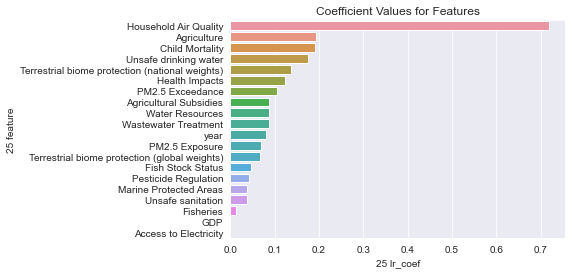

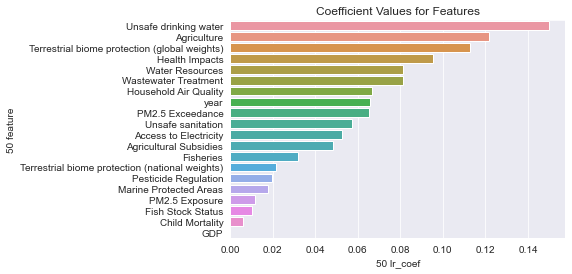

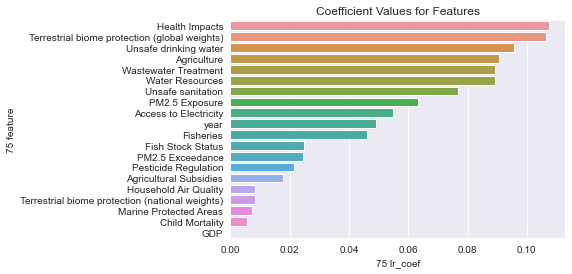

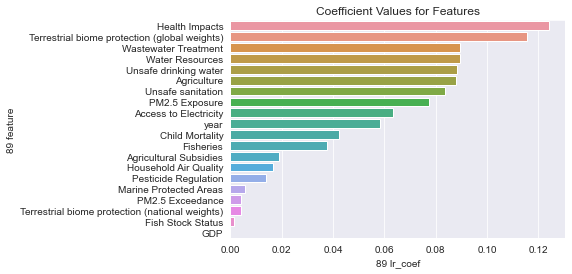

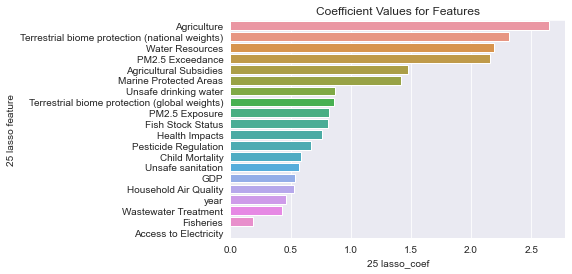

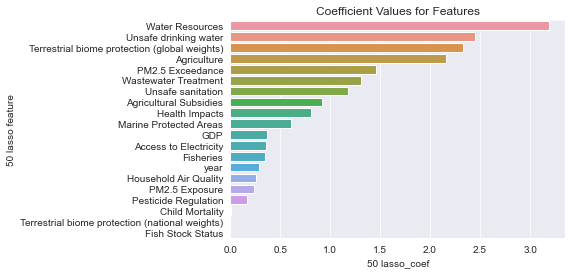

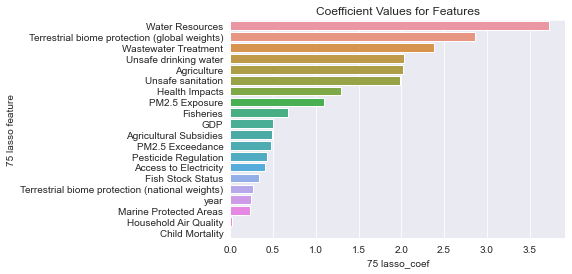

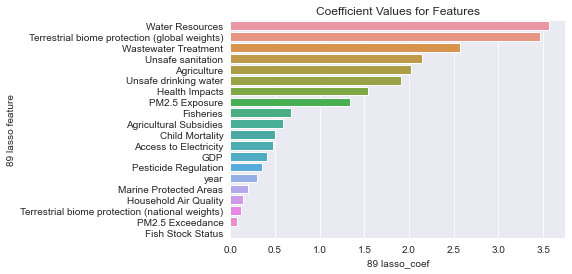

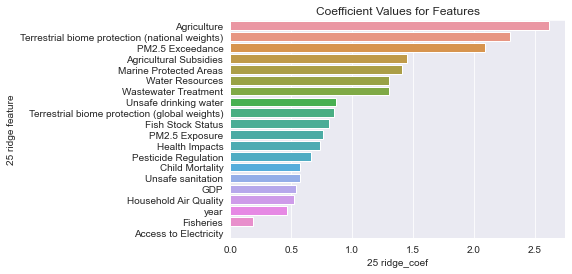

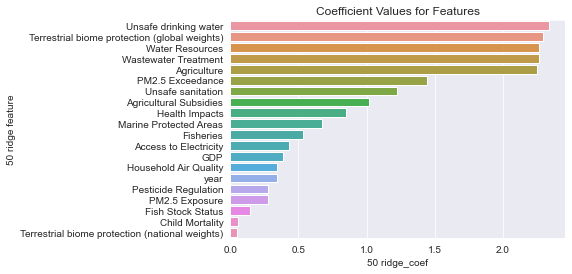

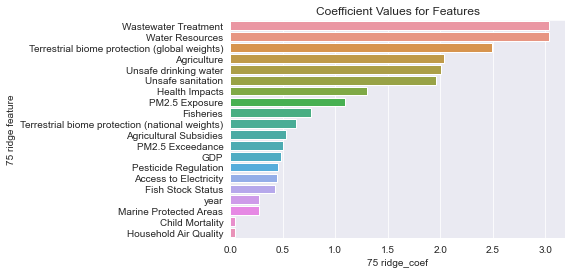

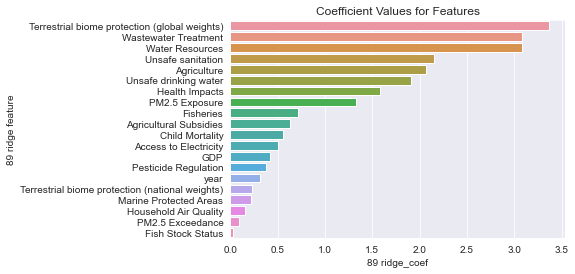

In [26]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = top_countries_df.iloc[:,y_counter],
    x = top_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


Bottom countries:

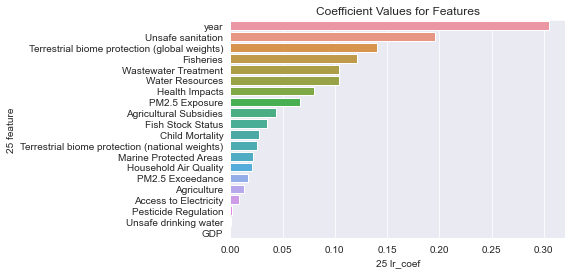

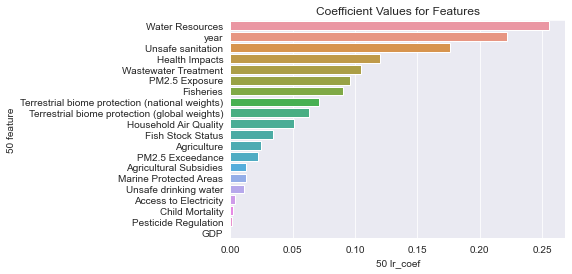

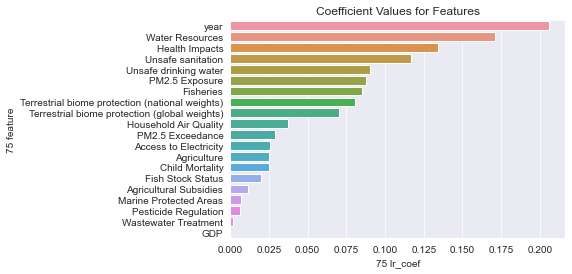

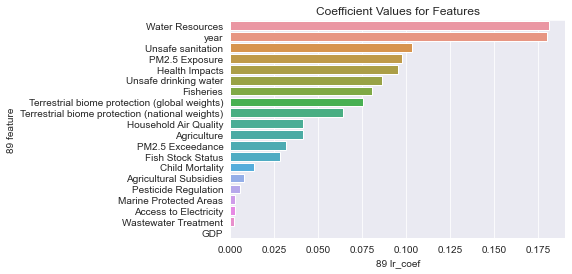

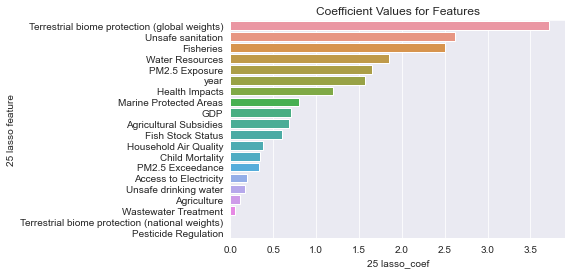

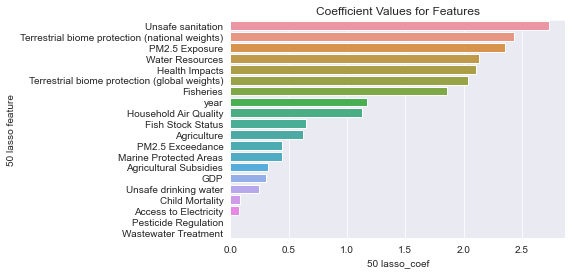

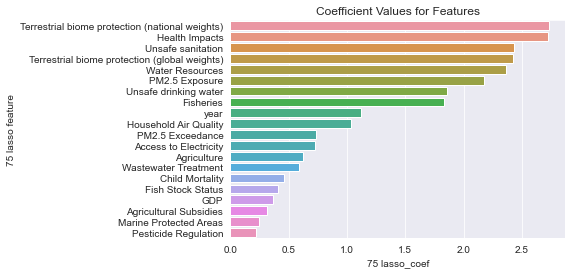

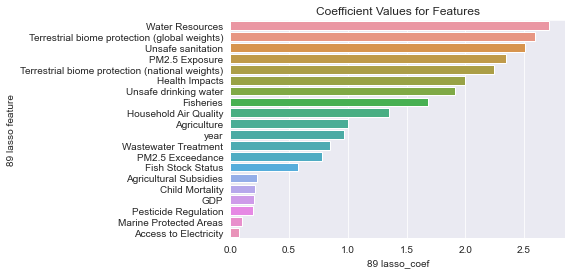

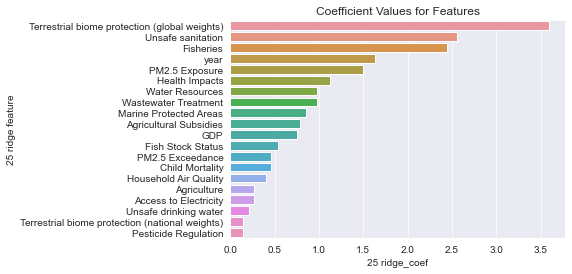

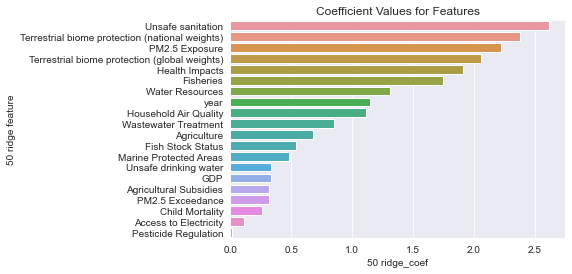

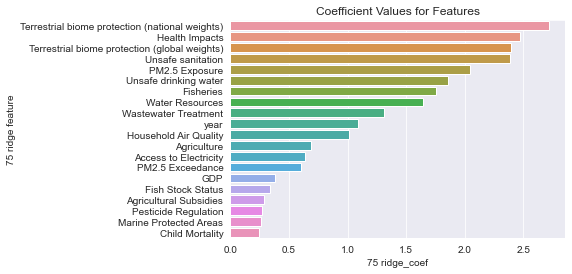

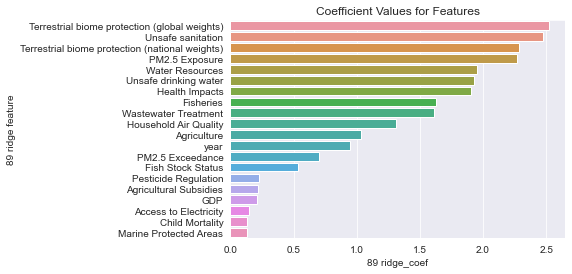

In [29]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = bot_countries_df.iloc[:,y_counter],
    x = bot_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


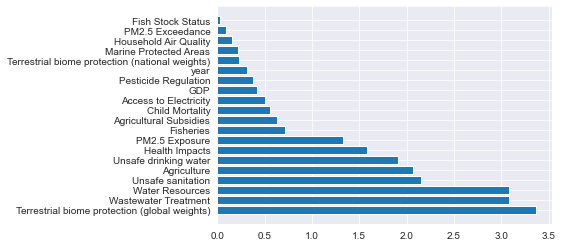

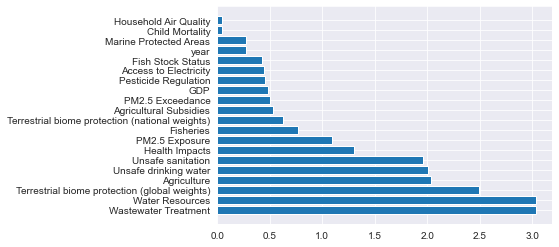

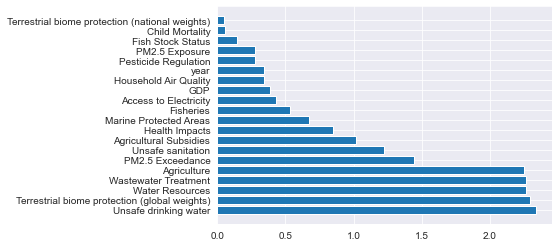

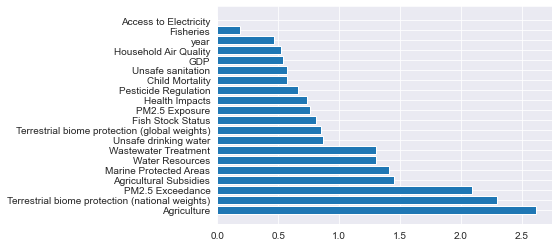

In [59]:

plt.barh( top_countries_df['89 ridge feature'], top_countries_df['89 ridge_coef'])
plt.show()
plt.barh(top_countries_df['75 ridge feature'], top_countries_df['75 ridge_coef'])
plt.show()
plt.barh(top_countries_df['50 ridge feature'], top_countries_df['50 ridge_coef'])
plt.show()
plt.barh(top_countries_df['25 ridge feature'], top_countries_df['25 ridge_coef'])
plt.show()

pre 2015

In [62]:
df_pre_2015 = df[df['year'] <=2015].copy()

In [63]:
df_pre_2015

,year,country_name,Sanitation & Drinking Water,Unsafe drinking water,PM2.5 Exposure,Air Quality,Marine Protected Areas,Biodiversity & Habitat,Ecosystem Vitality,Wastewater Treatment,...,Agriculture,Fisheries,PM2.5 Exceedance,Household Air Quality,Access to Electricity,Health Impacts,Agricultural Subsidies,Child Mortality,Pesticide Regulation,GDP
0,2002,Mexico,35.440,41.86,91.43,81.34,80.190,56.46,43.26,37.450,...,46.50,26.34,69.78,82.80,98.20,70.920,21.00,70.92,72.0,7.420000e+11
1,2003,Mexico,36.470,43.07,90.67,80.98,80.190,58.20,43.85,37.450,...,60.54,20.82,69.06,83.20,98.30,71.500,41.07,71.50,80.0,7.130000e+11
2,2004,Mexico,37.530,44.34,92.13,82.32,80.190,59.97,45.85,37.450,...,90.00,21.67,71.22,83.60,98.40,72.040,100.00,72.04,80.0,7.700000e+11
3,2005,Mexico,38.630,45.65,91.92,82.26,81.340,59.87,44.00,37.450,...,54.62,21.12,70.86,84.00,98.50,72.560,29.25,72.56,80.0,8.660000e+11
4,2006,Mexico,39.760,47.02,94.25,84.01,81.340,60.26,44.02,37.450,...,53.29,20.99,73.38,84.40,98.60,73.100,26.58,73.10,80.0,9.650000e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,2011,Senegal,16.490,20.43,100.00,83.00,77.210,85.36,38.16,2.060,...,17.45,20.78,100.00,49.00,57.00,34.970,22.90,34.97,12.0,1.439078e+10
3353,2012,Senegal,16.490,20.43,100.00,83.00,77.210,85.36,38.16,2.060,...,17.45,20.78,100.00,49.00,57.00,35.020,22.90,35.02,12.0,1.422531e+10
3354,2013,Senegal,16.490,20.43,100.00,83.00,77.210,85.36,38.16,2.060,...,17.45,20.78,100.00,49.00,57.00,35.020,22.90,35.02,12.0,1.485106e+10
3355,2014,Senegal,16.490,20.43,100.00,83.00,77.210,85.36,38.16,2.060,...,17.45,20.78,100.00,49.00,57.00,35.020,22.90,35.02,12.0,1.530436e+10


In [64]:
lr_coefs25_top,lasso_coefs25_top,ridge_coefs25_top = quick_regressions(25,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.7693451559765786
basic line reg scores: test:0.7407500113867362
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.7668079135526996
lasso line reg scores: test:0.7406330440834443
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.7686912151063585
ridge line reg scores: test:0.737532501595116


In [65]:
lr_coefs50_top,lasso_coefs50_top,ridge_coefs50_top = quick_regressions(50,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8821456823313151
basic line reg scores: test:0.8729381774451662
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.13957354246213, tolerance: 5.831429462129723
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.8820565942608465
lasso line reg scores: test:0.872709921425973
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8821122573290069
ridge line reg scores: test:0.8727565192779208


In [66]:
lr_coefs75_top,lasso_coefs75_top,ridge_coefs75_top = quick_regressions(75,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.909458653196017
basic line reg scores: test:0.900986954991972
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9094564197251903
lasso line reg scores: test:0.9010269787427871
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9093466348086243
ridge line reg scores: test:0.9012032836244817


In [67]:
lr_coefs89_top,lasso_coefs89_top,ridge_coefs89_top = quick_regressions(89,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.917158042946844
basic line reg scores: test:0.9117623517672258
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9167014049294054
lasso line reg scores: test:0.9119107047894559
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9170696718969915
ridge line reg scores: test:0.9117056225772134


bot

In [68]:
lr_coefs25_bot,lasso_coefs25_bot,ridge_coefs25_bot = quick_regressions(25,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.9380771727055458
basic line reg scores: test:0.9405922353120187
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9379188372279141
lasso line reg scores: test:0.940949195931019
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9378016148051078
ridge line reg scores: test:0.9404150399080339


In [69]:
lr_coefs50_bot,lasso_coefs50_bot,ridge_coefs50_bot = quick_regressions(50,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8431853544760379
basic line reg scores: test:0.7445145762449847
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8418969498546169
lasso line reg scores: test:0.7501747350944086
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.842679088229203
ridge line reg scores: test:0.749660869464108


In [70]:
lr_coefs75_bot,lasso_coefs75_bot,ridge_coefs75_bot = quick_regressions(75,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8598791242466245
basic line reg scores: test:0.8614652260928852
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3240.749036949682, tolerance: 3.725469666308844
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.8597399755502436
lasso line reg scores: test:0.861126134443198
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8597370841528255
ridge line reg scores: test:0.8611488982374574


In [71]:
lr_coefs89_bot,lasso_coefs89_bot,ridge_coefs89_bot = quick_regressions(89,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8588643513286212
basic line reg scores: test:0.8555451387601118
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8588600784971294
lasso line reg scores: test:0.8557251444383676
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8588591461044078
ridge line reg scores: test:0.8556373061981423


In [72]:
top_countries_df = lr_coefs25_top.copy()
bot_countries_df = lr_coefs25_bot.copy()

In [73]:
top_df_list = [lr_coefs50_top, lr_coefs75_top, lr_coefs89_top, lasso_coefs25_top,
               lasso_coefs50_top, lasso_coefs75_top, lasso_coefs89_top, ridge_coefs25_top,
              ridge_coefs50_top, ridge_coefs75_top, ridge_coefs89_top]
bot_df_list =  [lr_coefs50_bot, lr_coefs75_bot, lr_coefs89_bot, lasso_coefs25_bot,
               lasso_coefs50_bot, lasso_coefs75_bot, lasso_coefs89_bot, ridge_coefs25_bot,
              ridge_coefs50_bot, ridge_coefs75_bot, ridge_coefs89_bot]

In [74]:
for i in top_df_list:
    top_countries_df[i.columns[0]] = i.iloc[:,0]
    top_countries_df[i.columns[1]] = i.iloc[:,1]

In [75]:
for i in bot_df_list:
    bot_countries_df[i.columns[0]] = i.iloc[:,0]
    bot_countries_df[i.columns[1]] = i.iloc[:,1]

In [76]:
top_countries_df.shape

(20, 24)

In [77]:
bot_countries_df.shape

(20, 24)

In [78]:
sns.set_style('darkgrid')

top countries

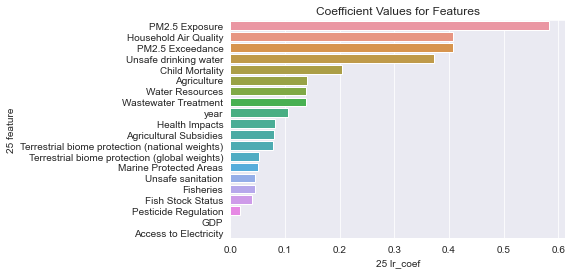

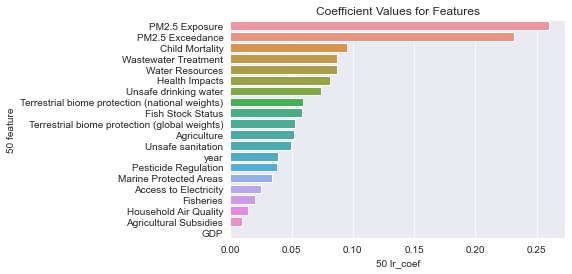

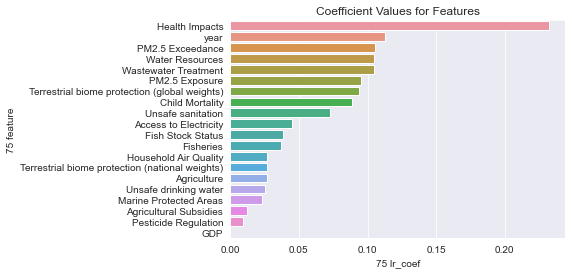

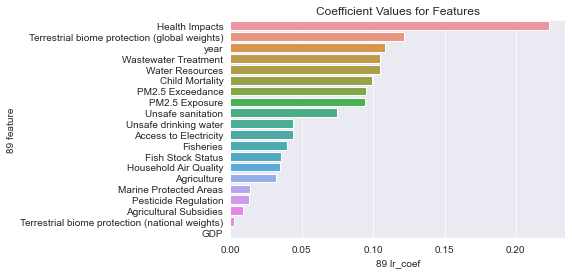

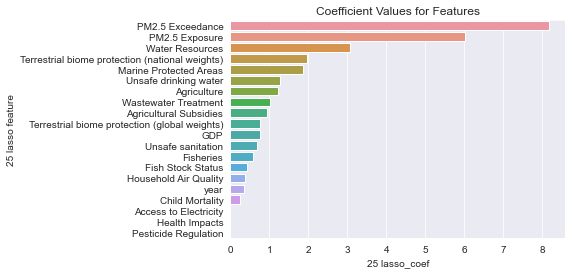

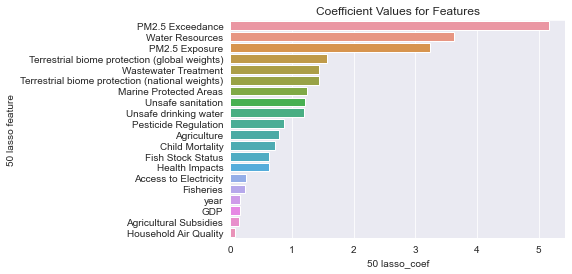

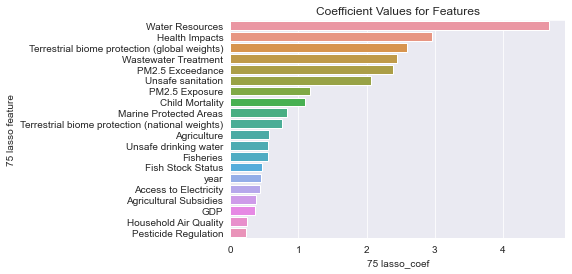

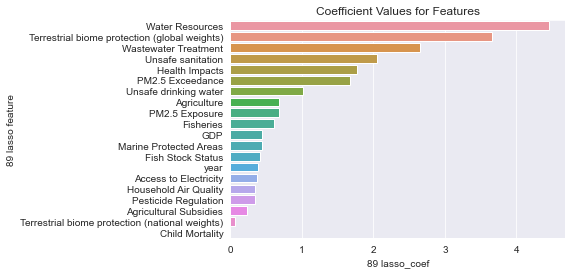

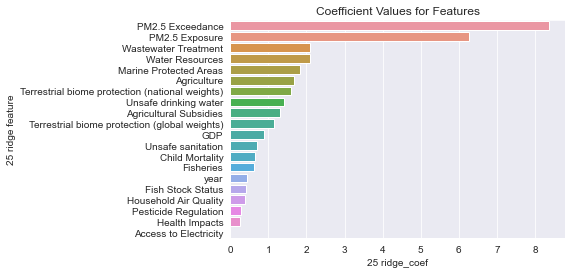

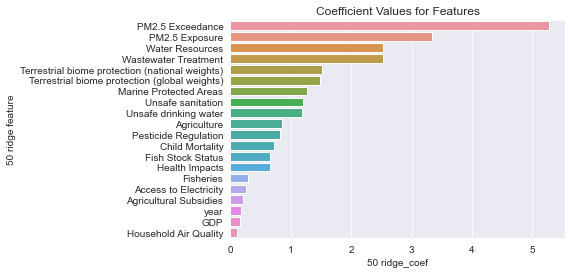

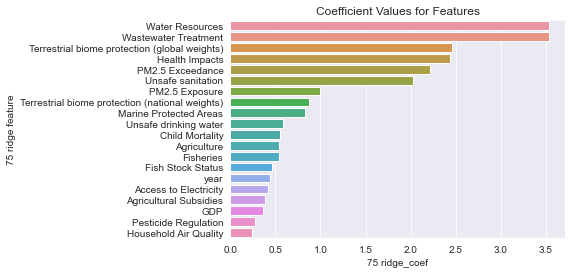

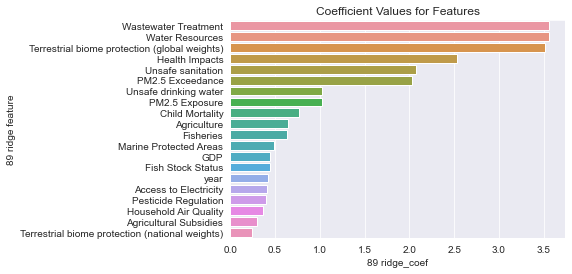

In [79]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = top_countries_df.iloc[:,y_counter],
    x = top_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


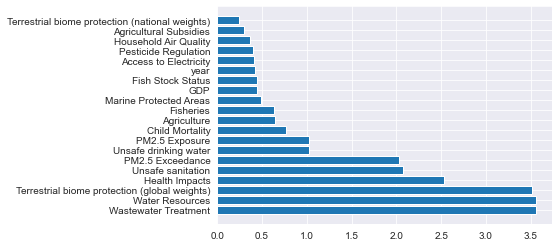

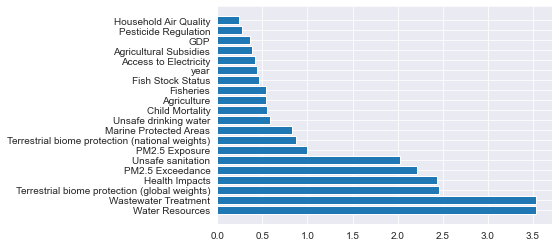

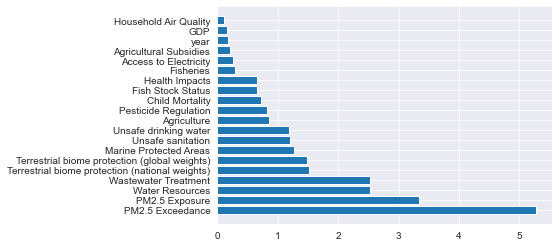

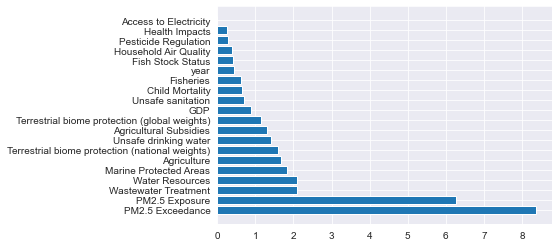

In [83]:
plt.barh( top_countries_df['89 ridge feature'], top_countries_df['89 ridge_coef'])
plt.show()
plt.barh(top_countries_df['75 ridge feature'], top_countries_df['75 ridge_coef'])
plt.show()
plt.barh(top_countries_df['50 ridge feature'], top_countries_df['50 ridge_coef'])
plt.show()
plt.barh(top_countries_df['25 ridge feature'], top_countries_df['25 ridge_coef'])
plt.show()

bot

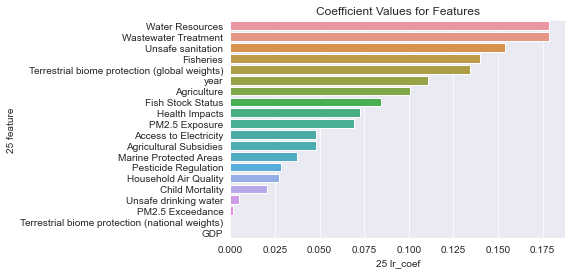

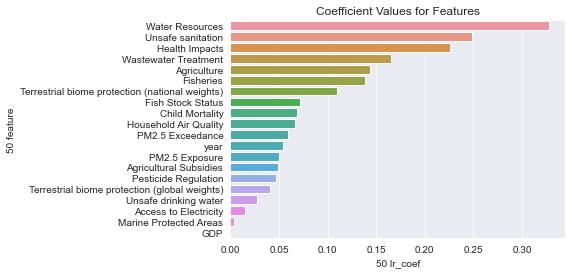

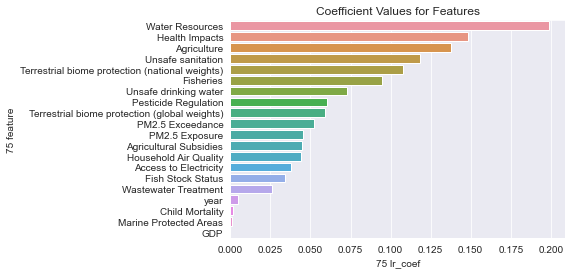

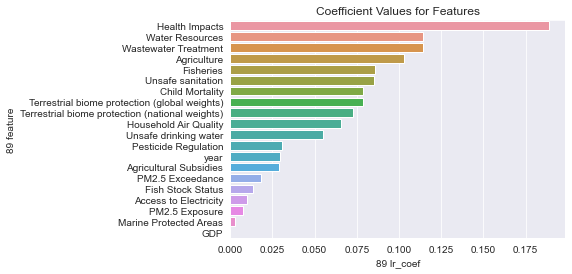

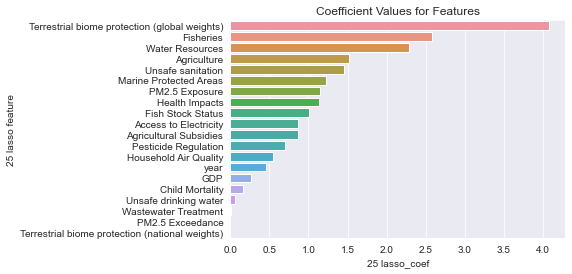

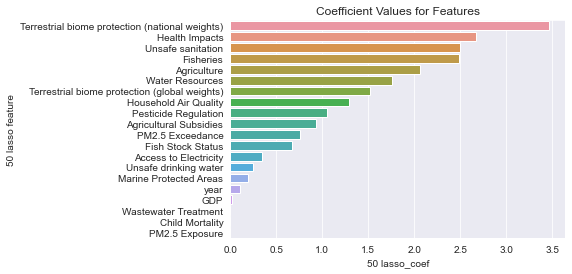

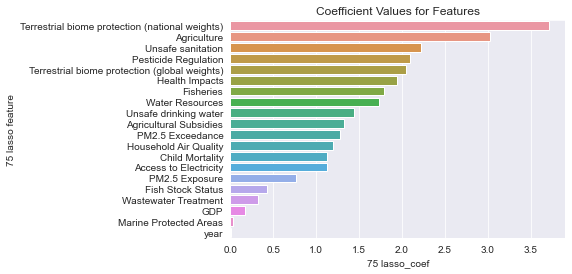

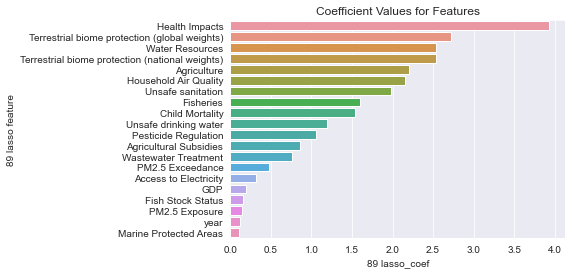

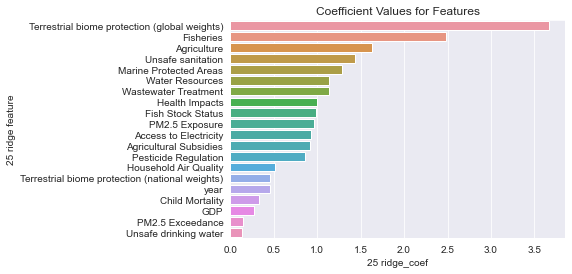

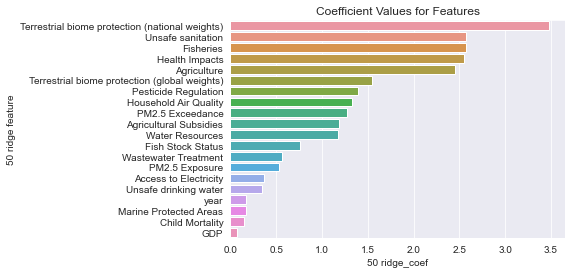

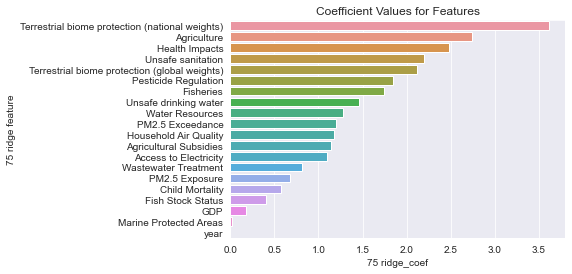

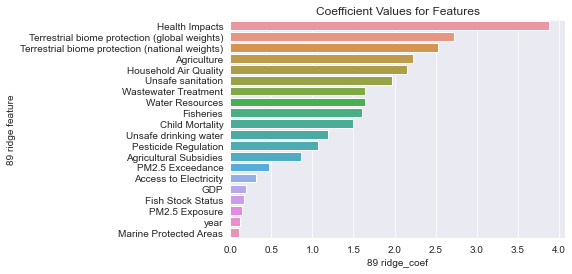

In [80]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = bot_countries_df.iloc[:,y_counter],
    x = bot_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


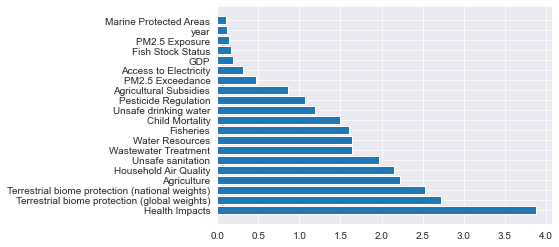

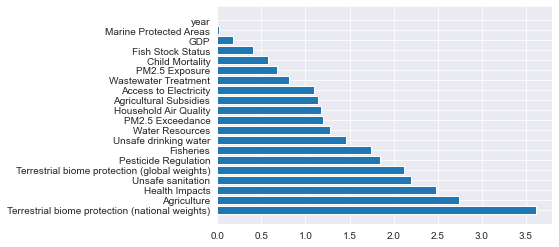

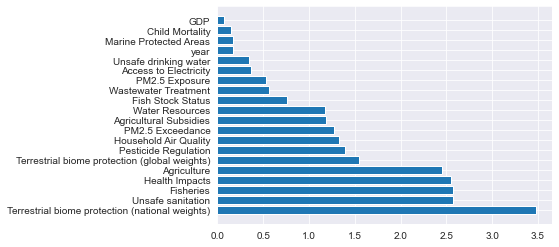

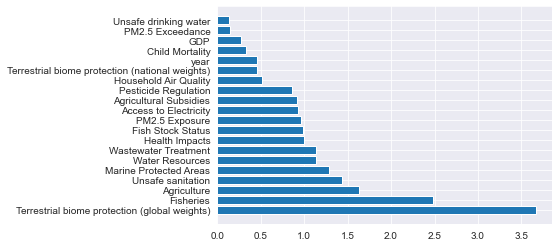

In [82]:

plt.barh( bot_countries_df['89 ridge feature'], bot_countries_df['89 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['75 ridge feature'], bot_countries_df['75 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['50 ridge feature'], bot_countries_df['50 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['25 ridge feature'], bot_countries_df['25 ridge_coef'])
plt.show()

In [84]:
df_post_2015 = df[df['year'] >2015].copy()

In [85]:
df_post_2015

,year,country_name,Sanitation & Drinking Water,Unsafe drinking water,PM2.5 Exposure,Air Quality,Marine Protected Areas,Biodiversity & Habitat,Ecosystem Vitality,Wastewater Treatment,...,Agriculture,Fisheries,PM2.5 Exceedance,Household Air Quality,Access to Electricity,Health Impacts,Agricultural Subsidies,Child Mortality,Pesticide Regulation,GDP
14,2016,Mexico,80.790,86.630,97.450,79.550,89.30,78.660,69.610,80.320,...,79.140,55.26,70.820,89.12,97.84,72.40,30.41,76.67,80.0,2.383250e+12
15,2017,Mexico,69.185,72.060,92.570,75.725,94.65,76.670,62.535,85.900,...,56.435,50.96,78.665,89.12,97.84,72.40,30.41,76.67,80.0,2.468830e+12
16,2018,Mexico,57.580,57.490,87.690,71.900,100.00,74.680,55.460,91.480,...,33.730,46.66,86.510,89.12,97.84,72.40,30.41,76.67,80.0,2.567830e+12
17,2019,Mexico,55.190,53.645,64.945,56.350,100.00,73.790,55.680,61.540,...,36.265,29.73,86.510,89.12,97.84,72.40,30.41,76.67,80.0,2.671950e+12
18,2020,Mexico,52.800,49.800,42.200,40.800,100.00,72.900,55.900,31.600,...,38.800,12.80,86.510,89.12,97.84,72.40,30.41,76.67,80.0,2.671950e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,2016,Senegal,57.020,57.310,100.000,75.780,82.92,93.360,67.100,34.290,...,95.030,60.58,100.000,62.44,76.82,48.27,22.90,35.02,12.0,4.611911e+10
3358,2017,Senegal,35.345,35.660,100.000,69.780,82.66,92.515,58.965,38.490,...,60.760,64.65,100.000,62.44,76.82,48.27,22.90,35.02,12.0,4.940217e+10
3359,2018,Senegal,13.670,14.010,100.000,63.780,82.40,91.670,50.830,42.690,...,26.490,68.72,100.000,62.44,76.82,48.27,22.90,35.02,12.0,5.383402e+10
3360,2019,Senegal,13.385,13.455,66.900,44.590,44.65,80.185,44.215,21.595,...,32.545,40.76,100.000,62.44,76.82,48.27,22.90,35.02,12.0,5.777225e+10


In [86]:
lr_coefs25_top,lasso_coefs25_top,ridge_coefs25_top = quick_regressions(25,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.843326955784725
basic line reg scores: test:0.8197582539025254
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.831003696254347
lasso line reg scores: test:0.8127820472139927
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8293762978066337
ridge line reg scores: test:0.803741295205778


In [87]:
lr_coefs50_top,lasso_coefs50_top,ridge_coefs50_top = quick_regressions(50,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.9236244951498196
basic line reg scores: test:0.850482694636935
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9158000762243714
lasso line reg scores: test:0.8300890068392308
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9231362237430502
ridge line reg scores: test:0.8496577762247133


In [88]:
lr_coefs75_top,lasso_coefs75_top,ridge_coefs75_top = quick_regressions(75,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.9161774610958529
basic line reg scores: test:0.9132620534638688
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9158885902789794
lasso line reg scores: test:0.9141305521763837
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9158194557076363
ridge line reg scores: test:0.9143540396885295


In [89]:
lr_coefs89_top,lasso_coefs89_top,ridge_coefs89_top = quick_regressions(89,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.9192949005201133
basic line reg scores: test:0.9227569315721088
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9190037366030268
lasso line reg scores: test:0.9213522090137451
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9186747164891663
ridge line reg scores: test:0.921294318215827


bot

In [90]:
lr_coefs25_bot,lasso_coefs25_bot,ridge_coefs25_bot = quick_regressions(25,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.880251302300534
basic line reg scores: test:0.7929927242252879
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8739785163805802
lasso line reg scores: test:0.8104105128554422
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8683868947703342
ridge line reg scores: test:0.7820883562527877


In [91]:
lr_coefs50_bot,lasso_coefs50_bot,ridge_coefs50_bot = quick_regressions(50,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8725037988583356
basic line reg scores: test:0.8742340072215486
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8686714590751263
lasso line reg scores: test:0.879496654824737
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8714671967906331
ridge line reg scores: test:0.8754237631051724


In [92]:
lr_coefs75_bot,lasso_coefs75_bot,ridge_coefs75_bot = quick_regressions(75,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8900860962377488
basic line reg scores: test:0.866801091209632
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8855893824420986
lasso line reg scores: test:0.8645001924791724
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8878843770436974
ridge line reg scores: test:0.8627349118679313


In [93]:
lr_coefs89_bot,lasso_coefs89_bot,ridge_coefs89_bot = quick_regressions(89,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.890627838338648
basic line reg scores: test:0.8789310540385055
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8898056798315139
lasso line reg scores: test:0.8793003561106629
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8897972400158961
ridge line reg scores: test:0.879085871026367


In [94]:
top_countries_df = lr_coefs25_top.copy()
bot_countries_df = lr_coefs25_bot.copy()

In [95]:
top_df_list = [lr_coefs50_top, lr_coefs75_top, lr_coefs89_top, lasso_coefs25_top,
               lasso_coefs50_top, lasso_coefs75_top, lasso_coefs89_top, ridge_coefs25_top,
              ridge_coefs50_top, ridge_coefs75_top, ridge_coefs89_top]
bot_df_list =  [lr_coefs50_bot, lr_coefs75_bot, lr_coefs89_bot, lasso_coefs25_bot,
               lasso_coefs50_bot, lasso_coefs75_bot, lasso_coefs89_bot, ridge_coefs25_bot,
              ridge_coefs50_bot, ridge_coefs75_bot, ridge_coefs89_bot]

In [96]:
for i in top_df_list:
    top_countries_df[i.columns[0]] = i.iloc[:,0]
    top_countries_df[i.columns[1]] = i.iloc[:,1]

In [97]:
for i in bot_df_list:
    bot_countries_df[i.columns[0]] = i.iloc[:,0]
    bot_countries_df[i.columns[1]] = i.iloc[:,1]

In [98]:
top_countries_df.shape

(20, 24)

In [99]:
bot_countries_df.shape

(20, 24)

In [100]:
sns.set_style('darkgrid')

top countries

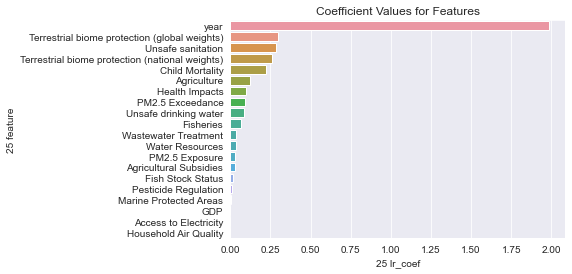

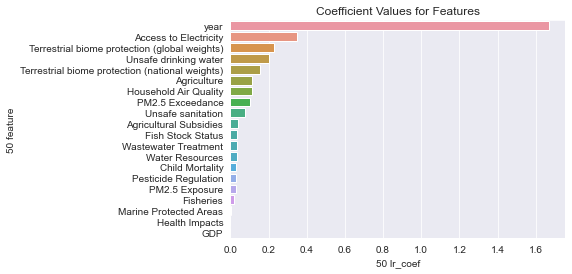

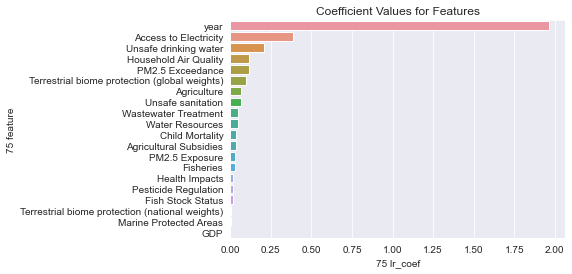

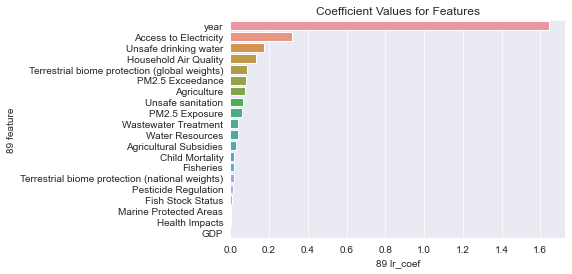

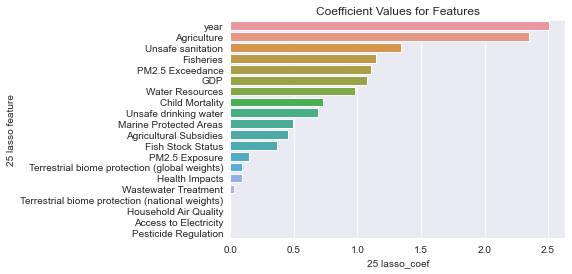

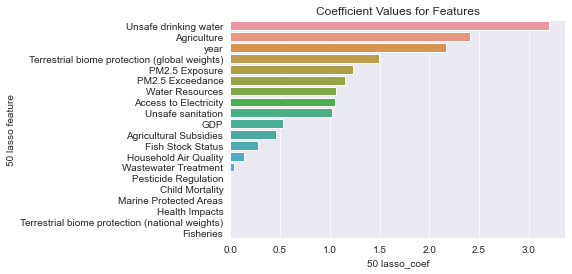

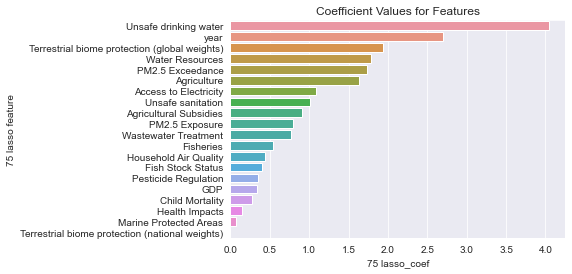

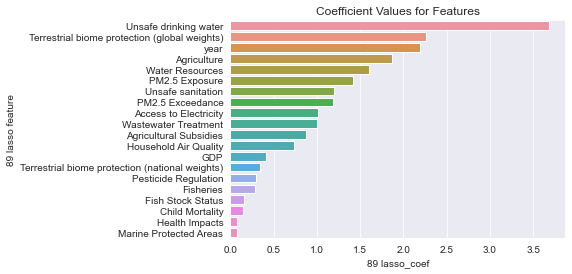

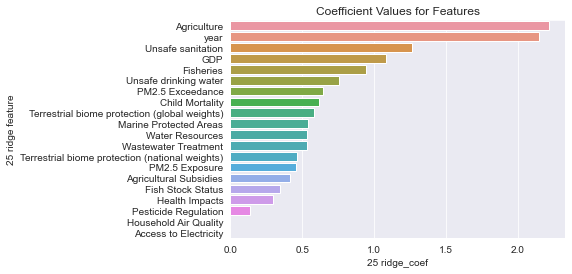

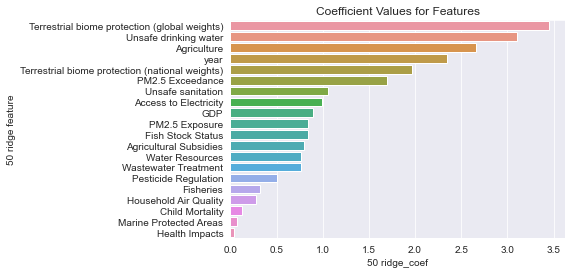

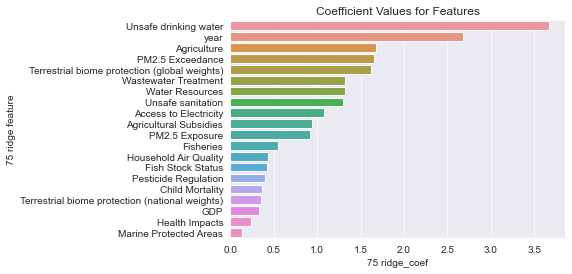

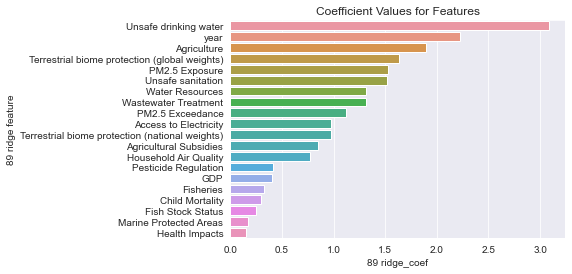

In [101]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = top_countries_df.iloc[:,y_counter],
    x = top_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


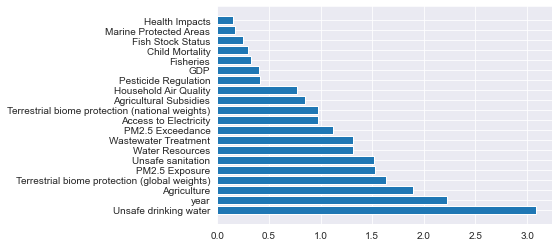

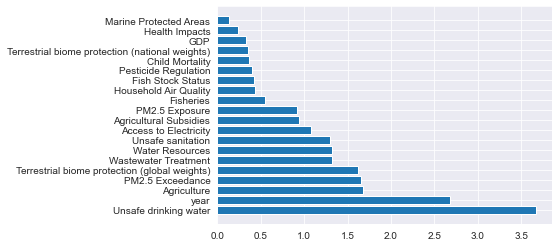

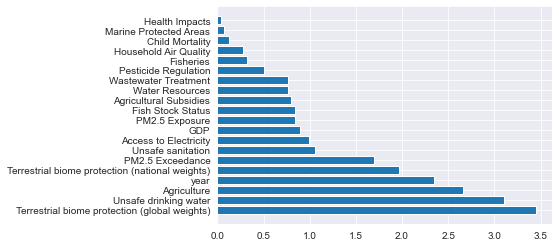

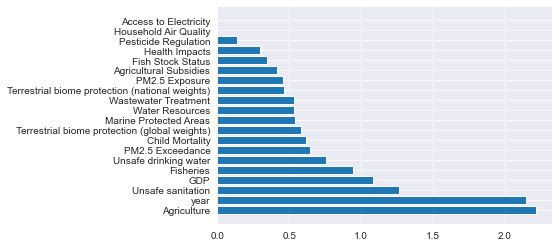

In [102]:
plt.barh( top_countries_df['89 ridge feature'], top_countries_df['89 ridge_coef'])
plt.show()
plt.barh(top_countries_df['75 ridge feature'], top_countries_df['75 ridge_coef'])
plt.show()
plt.barh(top_countries_df['50 ridge feature'], top_countries_df['50 ridge_coef'])
plt.show()
plt.barh(top_countries_df['25 ridge feature'], top_countries_df['25 ridge_coef'])
plt.show()

bot

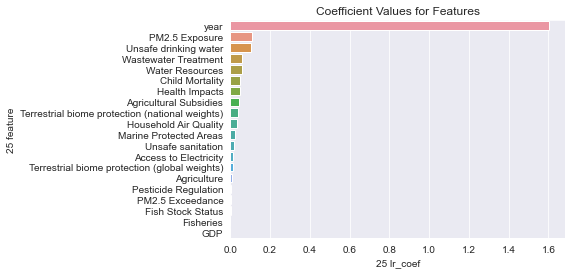

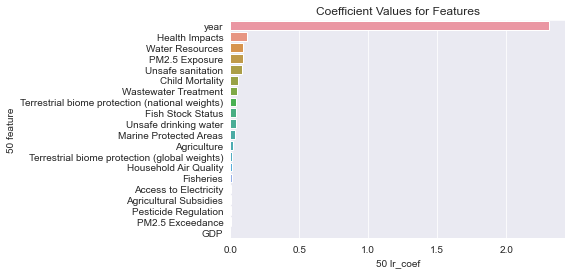

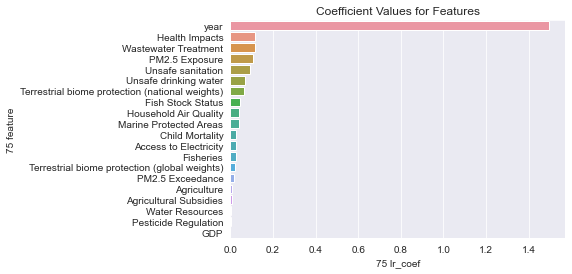

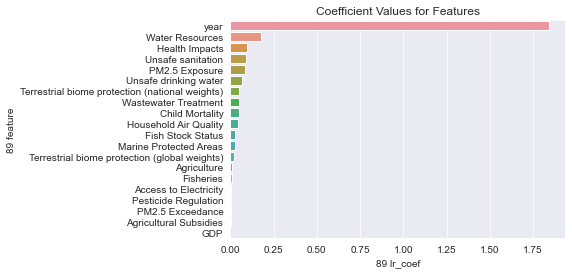

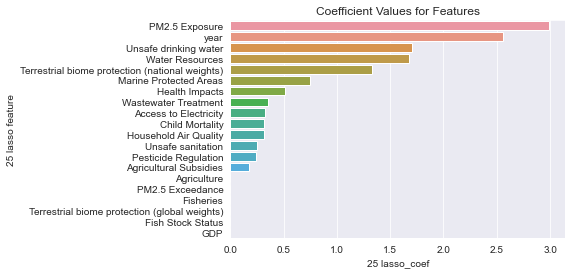

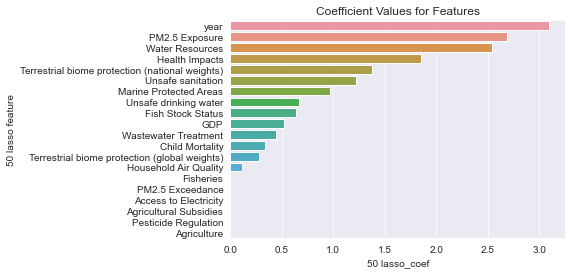

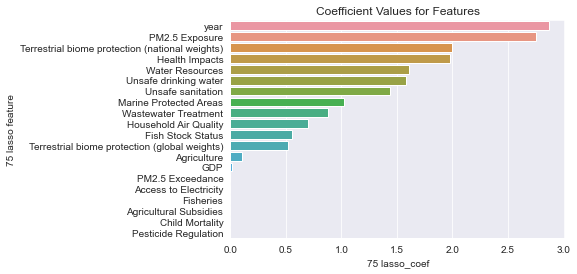

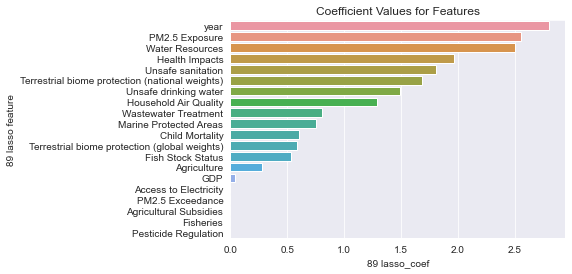

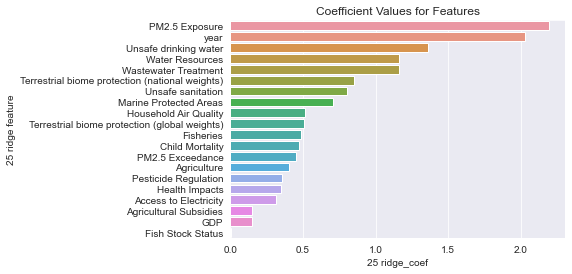

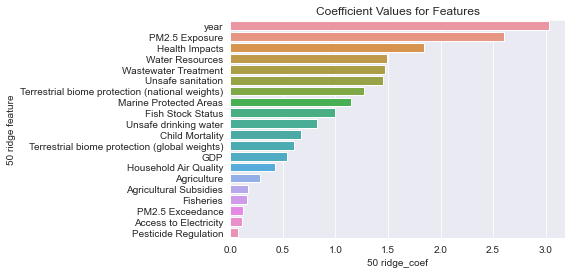

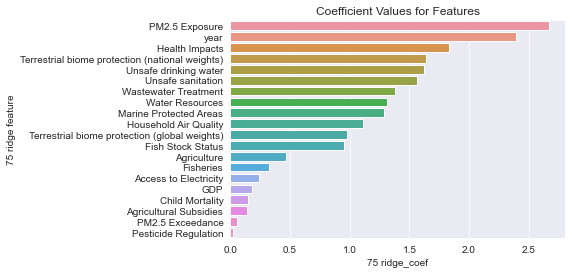

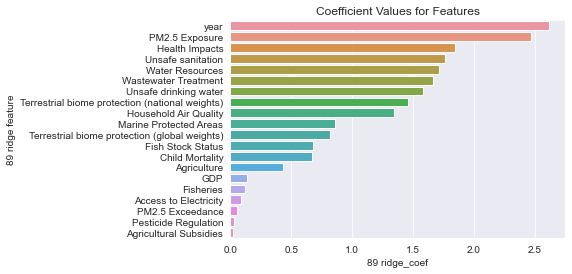

In [103]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = bot_countries_df.iloc[:,y_counter],
    x = bot_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


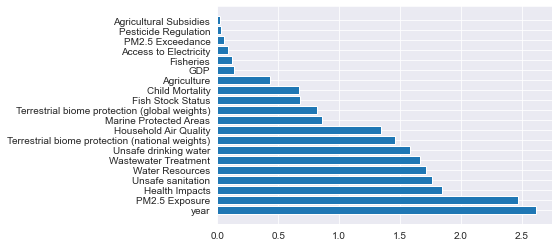

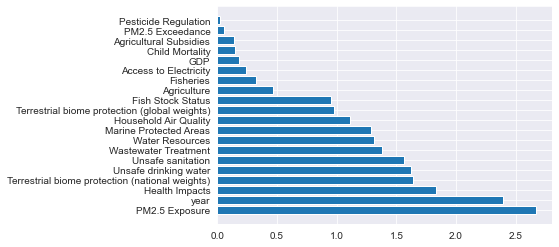

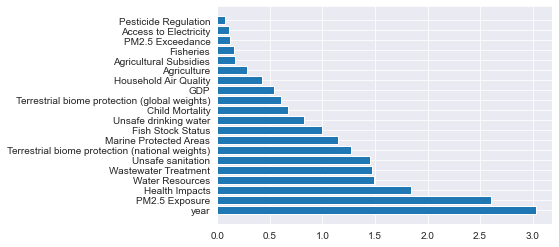

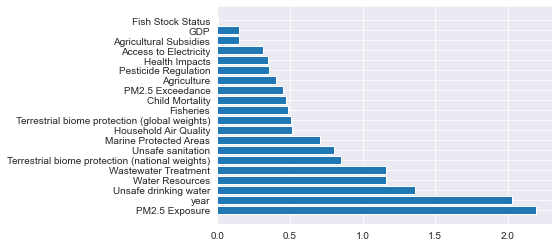

In [104]:

plt.barh( bot_countries_df['89 ridge feature'], bot_countries_df['89 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['75 ridge feature'], bot_countries_df['75 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['50 ridge feature'], bot_countries_df['50 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['25 ridge feature'], bot_countries_df['25 ridge_coef'])
plt.show()

extra practice / delete later

In [105]:
stop error

SyntaxError: invalid syntax (<ipython-input-105-b6379532b430>, line 1)

In [ ]:
X = top_10_df.drop(columns=drop_list)
y = top_10_df['Environmental Performance Index']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr.score(X_train,y_train), lr.score(X_test,y_test)

In [ ]:
print(list(zip(lr.coef_, X.columns)))

In [ ]:
coefs = pd.DataFrame(zip(lr.coef_, X.columns), columns=['coef', 'feature'])

In [ ]:
coefs = pd.DataFrame(zip(lr.coef_, X.columns), columns=['coef', 'feature'])
coefs.sort_values('coef',ascending=False, inplace=True)
coefs.reset_index(inplace=True)
coefs

In [ ]:
 sc = StandardScaler()
    
Xs_train = sc.fit_transform(X_train)
Xs_test = sc.transform(X_test)

#LASSO    
lasso = Lasso(random_state = 42, selection = 'random')

lasso_pipe_params = {
    'alpha': loguniform(.001, 100),
    'tol': loguniform(.00001, .001),
    'max_iter': uniform(100, 10000)
}

lasso_rs = RandomizedSearchCV(lasso, param_distributions = lasso_pipe_params, 
                         cv = 5,n_iter=1000,verbose=1, n_jobs = -2, random_state = 42)

lasso_rs.fit(Xs_train, y_train)

In [ ]:
lasso_rs.score(Xs_train,y_train), lasso_rs.score(Xs_test,y_test)

In [ ]:
lasso_rs.best_params_

In [ ]:
ridge = Ridge(random_state = 42)

ridge_pipe_params = {
    'alpha': loguniform(.001, 100),
    'tol': loguniform(.00001, .001),
    'max_iter': uniform(100, 10000)
}

ridge_rs = RandomizedSearchCV(ridge, param_distributions = ridge_pipe_params, cv = 5, n_jobs = -2,n_iter=1000,verbose=1, random_state = 42)
ridge_rs.fit(Xs_train, y_train)

In [ ]:
ridge_rs.score(Xs_train,y_train), ridge_rs.score(Xs_test,y_test)

In [ ]:
ridge_rs.best_estimator_.coef_

In [ ]:
ridge_rs.best_params_

pre2015

In [ ]:
top_10_df_pre15 = top_10_df[top_10_df['year'] <= 2015]
top_10_df_post15 = top_10_df[top_10_df['year'] > 2015]

In [ ]:
top_10_df_pre15

In [ ]:
top_10_df_post15

In [ ]:
X = top_10_df_post15.drop(columns=drop_list)
y = top_10_df_post15['Environmental Performance Index']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=.5)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr.score(X_train,y_train), lr.score(X_test,y_test)